In [2]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# load seaborn & set theme and plots look better
import seaborn as sns
sns.set_theme()
tuple([1, 2,"3", 3.5 ] + [4])


########### Everywhere Specificity --> actually Precision

(1, 2, '3', 3.5, 4)

In [11]:

################ LOADING & FORMATTING FUNCTIONS ################

def load_metrics(fname):
    with open(fname, 'rb') as handle:
        metrics = pickle.load(handle)
    return metrics

def calc_dice_score(intersection, sum_pred, sum_target, smoothing=0, dim='2D'):
    if dim == '2D':
        dice = (2 * intersection + smoothing) / (sum_pred + sum_target + smoothing)
    elif dim == '3D':
        dice = np.array([(2 * intersection.sum() + smoothing) / (sum_pred.sum() + sum_target.sum() + smoothing)])
    return dice

def calc_sensitivity(intersection, sum_target, dim='2D'):
    if dim == '2D':
        sens = (intersection) / (sum_target)
    elif dim == '3D':
        sens = np.array([(intersection).sum() / (sum_target).sum()])
    return sens

def calc_specificity(intersection, sum_pred, dim='2D'):
    if dim == '2D':
        spec = (intersection) / (sum_pred)
    elif dim == '3D':
        spec = np.array([(intersection).sum() / (sum_pred).sum()])
    return spec

def calc_continuous_dice_score(intersection, sum_pred, sum_target, c_denom, smoothing=0, dim='2D'):
    if dim == '2D':
        dice = (2 * intersection + smoothing) / ((intersection / c_denom) * sum_pred + sum_target + smoothing)
    elif dim == '3D':
        if intersection.sum() == 0:
            c = 1
        else:
            c = intersection.sum() / c_denom.sum()
        dice = np.array([(2 * intersection.sum() + smoothing) / (c * sum_pred.sum() + sum_target.sum() + smoothing)])
    return dice

def calc_volume(sums, spacing, dim='2D', metrics_in_mm=True):
    if metrics_in_mm == True:
        pixel_volume = spacing[0] * spacing[1] * spacing[2]
    else:
        pixel_volume = 1
        
    if dim == '2D':
        volume = sums * pixel_volume
    elif dim == '3D':
        volume = np.array([sums.sum() * pixel_volume])
    return volume

def calc_hausdorff(distances, spacing=None, dim='2D', metrics_in_mm=True):
    if metrics_in_mm == True:
        pixel_distance = spacing[0]
    else:
        pixel_distance = 1
        
    distances = distances[:].astype('float')
    distances[distances == 0] = float('nan')
    
    if dim == '2D':
        distance = distances * pixel_distance
    elif dim == '3D':
        distance = np.array([np.nanmax(distances * np.isfinite(distances)) * pixel_distance])
    return distance

def calc_thickness(thicknesses, spacing=None, dim='2D', metrics_in_mm=True):
    if metrics_in_mm == True:
        pixel_distance = spacing[0]
    else:
        pixel_distance = 1
    
    if dim == '2D':
        thickness = thicknesses * pixel_distance
    elif dim == '3D':
        thickness = np.array([thicknesses.max() * pixel_distance])
    return thickness

def calc_transmurality(thickness_myo, thickness_fib, dim='2D'):
    transmurality = calc_thickness(thickness_fib, None, dim=dim, metrics_in_mm=False) / calc_thickness(thickness_myo, None, dim=dim, metrics_in_mm=False) 
    return transmurality

def calc_scar_burden(sum_myo, sum_fib, dim='2D'):
    burden  = calc_volume(sum_fib, None, dim=dim, metrics_in_mm=False) / calc_volume(sum_myo, None, dim=dim, metrics_in_mm=False) 
    return burden

def calc_contact(contacts, spacing=None, dim='2D', metrics_in_mm=True):
    if metrics_in_mm == True:
        pixel_distance = spacing[0]
    else:
        pixel_distance = 1
    
    if dim == '2D':
        contact = contacts * pixel_distance
    elif dim == '3D':
        contact = np.array([contacts.sum() * pixel_distance])
    return contact

def calc_circumference(circumferences, spacing=None, dim='2D', metrics_in_mm=True):
    if metrics_in_mm == True:
        pixel_distance = spacing[0]
    else:
        pixel_distance = 1
    
    if dim == '2D':
        circumference = circumferences * pixel_distance
    elif dim == '3D':
        circumference = np.array([circumferences.sum() * pixel_distance])
    return circumference

def calc_ratio_contact_circumference(contacts, circumferences, dim='2D'):
    ratio = calc_contact(contacts, None, dim=dim, metrics_in_mm=False) / calc_circumference(circumferences, None, dim=dim, metrics_in_mm=False)
    return ratio

def calc_ratio_circumference_volume(circumferences, sums, dim='2D'):
    ratio = calc_contact(circumferences, None, dim=dim, metrics_in_mm=False) / calc_volume(sums, None, dim=dim, metrics_in_mm=False)
    return ratio




def create_dataframe(metric_dicts, classification_dict=None, char_df=None, dim='2D', require_multiple_slices=False, metrics_in_mm=True, gt_only=True):
    
    def _compute_metrics(sequence_dict, dim, require_multiple_slices, metrics_in_mm, gt_only, failed_features=False):
        column_names, metrics = [], []
        # Load data
        intersection_fib = np.array(sequence_dict['Intersection_fib'])
        intersection_myo = np.array(sequence_dict['Intersection_myo'])
        c_intersection_fib = np.array(sequence_dict['Continuous_intersection_fib'])
        c_intersection_myo = np.array(sequence_dict['Continuous_intersection_myo'])
        sum_gt_fib = np.array(sequence_dict['Sum_gt_fib'])
        sum_gt_myo = np.array(sequence_dict['Sum_gt_myo'])
        c_sum_gt_fib = np.array(sequence_dict['Continuous_sum_gt_fib'])
        c_sum_gt_myo = np.array(sequence_dict['Continuous_sum_gt_myo'])
        sum_pred_fib = np.array(sequence_dict['Sum_pred_fib'])
        sum_pred_myo = np.array(sequence_dict['Sum_pred_myo'])
        c_sum_pred_fib = np.array(sequence_dict['Continuous_sum_pred_fib'])
        c_sum_pred_myo = np.array(sequence_dict['Continuous_sum_pred_myo'])
        circumference_gt_fib = np.array(sequence_dict['Circumference_gt_fib'])
        circumference_gt_myo = np.array(sequence_dict['Circumference_gt_myo'])
        circumference_pred_fib = np.array(sequence_dict['Circumference_pred_fib'])
        circumference_pred_myo = np.array(sequence_dict['Circumference_pred_myo'])
        thickness_gt_fib = np.array(sequence_dict['Thickness_gt_fib'])
        thickness_gt_myo = np.array(sequence_dict['Thickness_gt_myo'])
        thickness_pred_fib = np.array(sequence_dict['Thickness_pred_fib'])
        thickness_pred_myo = np.array(sequence_dict['Thickness_pred_myo'])
        hausdorff_fib = np.array(sequence_dict['Hausdorff_fib'])
        hausdorff_myo = np.array(sequence_dict['Hausdorff_myo'])
        contact_gt_myo_fib = np.array(sequence_dict['Contact_gt_myo_fib'])
        contact_pred_myo_fib = np.array(sequence_dict['Contact_pred_myo_fib'])
        cdice_c_denom_fib = np.array(sequence_dict['Continuous_dice_c_denom_fib'])
        cdice_c_denom_myo = np.array(sequence_dict['Continuous_dice_c_denom_myo'])
        
        
        if require_multiple_slices == True:
            # if fibrosis is only predicted in one slice, set prediction and derivative stats to zero
            if (sum_pred_fib.max() == sum_pred_fib.sum()):
                intersection_fib = np.zeros_like(intersection_fib)
                sum_pred_fib = np.zeros_like(sum_pred_fib)
                circumference_pred_fib = np.zeros_like(circumference_pred_fib)
                thickness_pred_fib = np.zeros_like(thickness_pred_fib)
                contact_pred_myo_fib = np.zeros_like(contact_pred_myo_fib)
                
                
        if gt_only == True and sequence_dict['Ground_truth_segmentations_available'] == True:
            ########## True metrics (directy compares prediction with ground truth)        
            # Dice
            column_names.append('Dice_fibrosis')
            metrics.append(calc_dice_score(intersection_fib, sum_pred_fib, sum_gt_fib, smoothing=0, dim=dim))

            column_names.append('Dice_fibrosis_smooth')
            metrics.append(calc_dice_score(intersection_fib, sum_pred_fib, sum_gt_fib, smoothing=1, dim=dim))

            column_names.append('Dice_myocardium')
            metrics.append(calc_dice_score(intersection_myo, sum_pred_myo, sum_gt_myo, smoothing=0, dim=dim))

            column_names.append('Dice_myocardium_smooth')
            metrics.append(calc_dice_score(intersection_myo, sum_pred_myo, sum_gt_myo, smoothing=1, dim=dim))
            
            # continuous Dice
            column_names.append('Continuous_Dice_fibrosis')
            metrics.append(calc_continuous_dice_score(c_intersection_fib, c_sum_pred_fib, sum_gt_fib, cdice_c_denom_fib, smoothing=0, dim=dim))

            column_names.append('Continuous_Dice_fibrosis_smooth')
            metrics.append(calc_continuous_dice_score(c_intersection_fib, c_sum_pred_fib, sum_gt_fib, cdice_c_denom_fib, smoothing=1, dim=dim))

            column_names.append('Continuous_Dice_myocardium')
            metrics.append(calc_continuous_dice_score(c_intersection_myo, c_sum_pred_myo, sum_gt_myo, cdice_c_denom_myo, smoothing=0, dim=dim))

            column_names.append('Continuous_Dice_myocardium_smooth')
            metrics.append(calc_continuous_dice_score(c_intersection_myo, c_sum_pred_myo, sum_gt_myo, cdice_c_denom_myo, smoothing=1, dim=dim))

            # Sensitivity
            column_names.append('Sensitivity_fibrosis')
            metrics.append(calc_sensitivity(intersection_fib, sum_gt_fib, dim=dim))
            
            column_names.append('Sensitivity_myocardium')
            metrics.append(calc_sensitivity(intersection_myo, sum_gt_myo, dim=dim))
            
            # Specificity
            column_names.append('Specificity_fibrosis')
            metrics.append(calc_specificity(intersection_fib, sum_pred_fib, dim=dim))
            
            column_names.append('Specificity_myocardium')
            metrics.append(calc_specificity(intersection_myo, sum_pred_myo, dim=dim))
            
            # Hausdorff
            if failed_features == True:
                column_names.append('Hausdorff_fibrosis')
                metrics.append(calc_hausdorff(hausdorff_fib, dim=dim, metrics_in_mm=metrics_in_mm, spacing=sequence_dict['Resampled_spacing']))

                column_names.append('Hausdorff_myocardium')
                metrics.append(calc_hausdorff(hausdorff_myo, dim=dim, metrics_in_mm=metrics_in_mm, spacing=sequence_dict['Resampled_spacing']))

            if 'Hausdorff_3D_fib' in sequence_dict and dim == '3D':
                column_names.append('Hausdorff_3D_fib')
                metrics.append(np.array([sequence_dict['Hausdorff_3D_fib']]))
                
                column_names.append('Hausdorff95_3D_fib')
                metrics.append(np.array([sequence_dict['Hausdorff95_3D_fib']]))
                
                column_names.append('Hausdorff_3D_myo')
                metrics.append(np.array([sequence_dict['Hausdorff_3D_myo']]))
                column_names.append('Hausdorff95_3D_myo')
                metrics.append(np.array([sequence_dict['Hausdorff95_3D_myo']]))
            

            ######### Other parameters (calculated for both ground truth and prediction, accuracy to be determined later)

            # Volume
            column_names.append('Volume_ground_truth_fibrosis')
            metrics.append(calc_volume(sum_gt_fib, dim=dim, metrics_in_mm=metrics_in_mm, spacing=sequence_dict['Resampled_spacing']))
        
            column_names.append('Volume_ground_truth_myocardium')
            metrics.append(calc_volume(sum_gt_myo, dim=dim, metrics_in_mm=metrics_in_mm, spacing=sequence_dict['Resampled_spacing']))
            # Continuous Volume
            column_names.append('Continuous_Volume_ground_truth_fibrosis')
            metrics.append(calc_volume(c_sum_gt_fib, dim=dim, metrics_in_mm=metrics_in_mm, spacing=sequence_dict['Resampled_spacing']))
        
            column_names.append('Continuous_Volume_ground_truth_myocardium')
            metrics.append(calc_volume(c_sum_gt_myo, dim=dim, metrics_in_mm=metrics_in_mm, spacing=sequence_dict['Resampled_spacing']))
            
            if failed_features == True:
                # Thickness
                column_names.append('Thickness_ground_truth_fibrosis')
                metrics.append(calc_thickness(thickness_gt_fib, dim=dim, metrics_in_mm=metrics_in_mm, spacing=sequence_dict['Resampled_spacing']))

                column_names.append('Thickness_ground_truth_myocardium')
                metrics.append(calc_thickness(thickness_gt_myo, dim=dim, metrics_in_mm=metrics_in_mm, spacing=sequence_dict['Resampled_spacing']))

                # Transmurality
                column_names.append('Transmurality_ground_truth')
                metrics.append(calc_transmurality(thickness_gt_myo, thickness_gt_fib, dim=dim))

            # Scar burden
            column_names.append('Scar_burden_ground_truth')
            metrics.append(calc_scar_burden(sum_gt_myo, sum_gt_fib, dim=dim))
            # Continuous Scar burden
            column_names.append('Continuous_Scar_burden_ground_truth')
            metrics.append(calc_scar_burden(c_sum_gt_myo, c_sum_gt_fib, dim=dim))
            
            if failed_features == True:
                # Contact myocardium-fibrosis
                column_names.append('Contact_ground_truth')
                metrics.append(calc_contact(contact_gt_myo_fib, dim=dim, metrics_in_mm=metrics_in_mm, spacing=sequence_dict['Resampled_spacing']))
        
            # Circumference
            column_names.append('Circumference_ground_truth_fibrosis')
            metrics.append(calc_circumference(circumference_gt_fib, dim=dim, metrics_in_mm=metrics_in_mm, spacing=sequence_dict['Resampled_spacing']))
        
            column_names.append('Circumference_ground_truth_myocardium')
            metrics.append(calc_circumference(circumference_gt_myo, dim=dim, metrics_in_mm=metrics_in_mm, spacing=sequence_dict['Resampled_spacing']))
            
            if failed_features == True:
                # Ratio contact myocardium-fibrosis circumference fibrosis
                column_names.append('Ratio_contact_circumference_ground_truth')
                metrics.append(calc_ratio_contact_circumference(contact_gt_myo_fib, circumference_gt_fib, dim=dim))

            # Ratio circumferece / volume
            column_names.append('Ratio_circumference_volume_ground_truth_fibrosis')
            metrics.append(calc_ratio_circumference_volume(circumference_gt_fib, sum_gt_fib, dim=dim))

            column_names.append('Ratio_circumference_volume_ground_truth_myocardium')
            metrics.append(calc_ratio_circumference_volume(circumference_gt_myo, sum_gt_myo, dim=dim))
        
        
        # Volume
        column_names.append('Volume_prediction_fibrosis')
        metrics.append(calc_volume(sum_pred_fib, dim=dim, metrics_in_mm=metrics_in_mm, spacing=sequence_dict['Resampled_spacing']))
        
        column_names.append('Volume_prediction_myocardium')
        metrics.append(calc_volume(sum_pred_myo, dim=dim, metrics_in_mm=metrics_in_mm, spacing=sequence_dict['Resampled_spacing']))
        # Continuous Volume
        column_names.append('Continuous_Volume_prediction_fibrosis')
        metrics.append(calc_volume(c_sum_pred_fib, dim=dim, metrics_in_mm=metrics_in_mm, spacing=sequence_dict['Resampled_spacing']))
        
        column_names.append('Continuous_Volume_prediction_myocardium')
        metrics.append(calc_volume(c_sum_pred_myo, dim=dim, metrics_in_mm=metrics_in_mm, spacing=sequence_dict['Resampled_spacing']))
        
        if failed_features == True:
            #Thickness
            column_names.append('Thickness_prediction_fibrosis')
            metrics.append(calc_thickness(thickness_pred_fib, dim=dim, metrics_in_mm=metrics_in_mm, spacing=sequence_dict['Resampled_spacing']))

            column_names.append('Thickness_prediction_myocardium')
            metrics.append(calc_thickness(thickness_pred_myo, dim=dim, metrics_in_mm=metrics_in_mm, spacing=sequence_dict['Resampled_spacing']))

            # Transmurality
            column_names.append('Transmurality_prediction')
            metrics.append(calc_transmurality(thickness_pred_myo, thickness_pred_fib, dim=dim))

        # Scar burden
        column_names.append('Scar_burden_prediction')
        metrics.append(calc_scar_burden(sum_pred_myo, sum_pred_fib, dim=dim))
        # Continuous Scar burden
        column_names.append('Continuous_Scar_burden_prediction')
        metrics.append(calc_scar_burden(c_sum_pred_myo, c_sum_pred_fib, dim=dim))
        
        if failed_features == True:
            # Contact myocardium-fibrosis
            column_names.append('Contact_prediction')
            metrics.append(calc_contact(contact_pred_myo_fib, dim=dim, metrics_in_mm=metrics_in_mm, spacing=sequence_dict['Resampled_spacing']))
        
        # Circumference
        column_names.append('Circumference_prediction_fibrosis')
        metrics.append(calc_circumference(circumference_pred_fib, dim=dim, metrics_in_mm=metrics_in_mm, spacing=sequence_dict['Resampled_spacing']))
        
        column_names.append('Circumference_prediction_myocardium')
        metrics.append(calc_circumference(circumference_pred_myo, dim=dim, metrics_in_mm=metrics_in_mm, spacing=sequence_dict['Resampled_spacing']))
        
        if failed_features == True:
            # Ratio contact myocardium-fibrosis / circumference fibrosis
            column_names.append('Ratio_contact_circumference_prediction')
            metrics.append(calc_ratio_contact_circumference(contact_pred_myo_fib, circumference_pred_fib, dim=dim))
        
        # Ratio circumference / volume
        column_names.append('Ratio_circumference_volume_prediction_fibrosis')
        metrics.append(calc_ratio_circumference_volume(circumference_pred_fib, sum_pred_fib, dim=dim))
        
        column_names.append('Ratio_circumference_volume_prediction_myocardium')
        metrics.append(calc_ratio_circumference_volume(circumference_pred_myo, sum_pred_myo, dim=dim))
    
        metrics = np.array(metrics).T
            
        
        return column_names, metrics
    
        
    assert dim in ['2D', '3D']
    
    data = []
    relevant_characteristics = ['Geslacht', 'Ischemische_ziekte', 'stabiel_coronairlijden', 'myocard_infarct',
                               'PCI', 'CABG', 'cardiomyopathie', 'ICD_LGE_aanwezig', 
                               'Eindpunt#Terechte_ICD_therapie_DEEPRISK1']
    columns = ["Model", "PID", "SID", "Split"]
    if not char_df is None:
        columns += relevant_characteristics
    
    for model in metric_dicts:
        for sid in metric_dicts[model]:
            if gt_only == True and metric_dicts[model][sid]['Ground_truth_segmentations_available'] == False:
                continue
            data_row_base = []
            pid = sid[:10]
            # add general per-stack attributes
            data_row_base.append(model)
            data_row_base.append(pid)
            data_row_base.append(sid)
            data_row_base.append(metric_dicts[model][sid]['Split'])
            # add characteristic from csv
            if not char_df is None:
                pid_char_df = char_df[char_df['SubjectID'] == pid]
                for c in relevant_characteristics:
                    data_row_base.append(pid_char_df[c].item())
            
            # add per-slice/per-stack metrics based on dim='2D'/dim='3D'
            metric_columns, sequence_metrics = _compute_metrics(metric_dicts[model][sid], dim, require_multiple_slices, metrics_in_mm, gt_only)
            if classification_dict != None:
                classification_predictions = classification_dict[sid]
                assert len(classification_predictions) == len(sequence_metrics)
            for slice_idx, slice_metrics in enumerate(sequence_metrics):
                data_row = data_row_base + slice_metrics.tolist()
                if classification_dict != None:
                    data_row.append(classification_predictions[slice_idx])
                
                data.append(tuple(data_row))
    columns = columns + metric_columns
    if classification_dict != None:
        columns.append('Fibrosis_classification_prediction')
    df = pd.DataFrame(data, columns=columns)
    return df

        
    

################ PLOTTING FUNCTIONS ################

def catplot(df, x='PID', y='Dice', hue="Ischemische_ziekte", col="Model", kind='strip', restrictions={}, fibrotic_patients_only=False):
    #assert x in df
    #assert y in df
    #assert hue in df
    #assert col in df
    sns_kwargs = {}
    if kind == 'violin':
        sns_kwargs['cut'] = 0
    elif kind == 'box':
        sns_kwargs['showmeans'] = True
        sns_kwargs['meanprops']={"markerfacecolor":"red"}
        
    for k, v in restrictions.items():
        df = df[df[k] == v]
    
    if fibrotic_patients_only == True:
        df = df[df['Volume_ground_truth_fibrosis'] > 0]
        
    if hue != None:
        if len(df[hue].unique()) < 10:
            for hue_v in df[hue].unique():
                print(f"{hue_v}: mean {y}:{df[y][df[hue] == hue_v].mean(skipna=True):.4f}, std {df[y][df[hue] == hue_v].std(skipna=True):.4f}, median {y}:{df[y][df[hue] == hue_v].median(skipna=True):.4f}, IQR {df[y][df[hue] == hue_v].quantile(0.25):.4f}-{df[y][df[hue] == hue_v].quantile(0.75):.4f}")
        hue_values = df[hue]
        
    ax = sns.catplot(x=x, y=y, hue=hue, data=df, kind=kind, col=col, **sns_kwargs)
    if x == 'PID':
        ax.set_xticklabels(rotation=90)    
    
    plt.show()
    return

def relplot(df, x="Scar_Volume_pred", y="Scar_Volume_gt", hue="Ischemische_ziekte", col="Model", kind='scatter', diagonal=True, restrictions={}, show_correlation=False, fibrotic_patients_only=False):
    sns_kwargs = {}
    for k, v in restrictions.items():
        df = df[df[k] == v]
        
    if fibrotic_patients_only == True:
        df = df[df['Volume_ground_truth_fibrosis'] > 0]
        
    def diagonal_line(lim=17500, *args, **kwargs):
        #print(f"{lim=}")
        plt.plot([0, lim], [0, lim], linestyle='--')
        
    def annotate(data, **kwargs):
        n = len(data)
        corr_restrictions = restrictions
        corr_restrictions[col] = data[col].unique()[0]
        correlation = collect_correlations(df, columns=[x, y],
                                          restrictions=restrictions)
        #print(correlation)
        ax = plt.gca()
        ax.text(.1, .6, f"Correlation = {correlation.values[0,1]:.3f}", transform=ax.transAxes)        

    ax = sns.relplot(x=x, y=y, hue=hue, data=df, kind=kind, col=col, **sns_kwargs)
    #ax.set_xticklabels(rotation=90)
    if show_correlation == True:
        ax.map_dataframe(annotate)

    if diagonal == True:
        #print(ax.axes)
        lim = max(ax.axes[0][0].get_xlim()[1], ax.axes[0][0].get_ylim()[1])
        #lim = max(ax.ax.get_xlim()[1], ax.ax.get_ylim()[1])
        ax.map(diagonal_line, lim=lim)
    plt.show()
    return
    



In [178]:
char_df = pd.read_excel(r"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\data\mri_dataset_characteristics_30mar2022.xlsx")

#metric_dicts = {"Pixel-level,\n Training N=33": load_metrics(r"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs\unet_stacked_full\version_10\metrics.pkl"),
#                "Slice-level,\n Training N=431": load_metrics(r"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs\unet_weak2D\version_0\metrics.pkl"),
#                "Stack-level,\n Training N=431": load_metrics(r"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs\unet_weak3D\version_0\metrics.pkl")}

#metric_dicts = {"Pixel-level,\n myo input": load_metrics(r"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_segmentation_fib\full_myo_input\version_1\metrics.pkl"),
#                "Pixel-level,\n no myo input": load_metrics(r"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_segmentation_fib\full_no_myo_input\version_1\metrics.pkl"),
#                "Slice-level,\n myo input": load_metrics(r"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_segmentation_fib\slice_myo_input\version_1\metrics.pkl"),
#                "Slice-level,\n no myo input": load_metrics(r"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_segmentation_fib\slice_no_myo_input\version_1\metrics.pkl"),
#                "Stack-level,\n myo input": load_metrics(r"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_segmentation_fib\stack_myo_input\version_1\metrics.pkl"),
#                "Stack-level,\n no myo input": load_metrics(r"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_segmentation_fib\stack_no_myo_input\version_2\metrics.pkl")}

#confidence_dfs = {}
#for thresh in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
#    confidence_dict =  {"Pixel-level,\n myo input": load_metrics(fr"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_segmentation_fib\full_myo_input\version_1\metrics@{thresh:.2f}.pkl"),
#                "Pixel-level,\n no myo input": load_metrics(fr"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_segmentation_fib\full_no_myo_input\version_1\metrics@{thresh:.2f}.pkl"),
#                "Slice-level,\n myo input": load_metrics(fr"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_segmentation_fib\slice_myo_input\version_1\metrics@{thresh:.2f}.pkl"),
#                "Slice-level,\n no myo input": load_metrics(fr"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_segmentation_fib\slice_no_myo_input\version_1\metrics@{thresh:.2f}.pkl"),
#                "Stack-level,\n myo input": load_metrics(fr"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_segmentation_fib\stack_myo_input\version_1\metrics@{thresh:.2f}.pkl"),
#                "Stack-level,\n no myo input": load_metrics(fr"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_segmentation_fib\stack_no_myo_input\version_2\metrics@{thresh:.2f}.pkl")}
#    confidence_dfs[thresh] = create_dataframe(confidence_dict, char_df, dim="3D", metrics_in_mm=True, gt_only=True, require_multiple_slices=False)
best_deeprisk_dict = {"Pixel-level,\n no myo input": load_metrics(fr"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_segmentation_fib\full_no_myo_input\version_2\deepriskmetrics@{0.9:.2f}.pkl"),
                       "Pixel-level,\n myo input": load_metrics(fr"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_segmentation_fib\full_myo_input\version_2\deepriskmetrics@{0.5:.2f}.pkl"),
                       "Slice-level,\n no myo input": load_metrics(fr"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_segmentation_fib\slice_no_myo\version_0\deepriskmetrics@{0.7:.2f}.pkl"),
                       "Slice-level,\n myo input": load_metrics(fr"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_segmentation_fib\slice_myo\version_0\deepriskmetrics@{0.9:.2f}.pkl"),
                       "Stack-level,\n no myo input": load_metrics(fr"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_segmentation_fib\stack_no_myo\version_0\deepriskmetrics@{0.9:.2f}.pkl"),
                       "Stack-level,\n myo input": load_metrics(fr"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_segmentation_fib\stack_myo\version_0\deepriskmetrics@{0.9:.2f}.pkl"),
                        "Pixel-level,\n myo input cascaded": load_metrics(fr"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_segmentation_fib\full_myo_input_cascaded\version_1\deepriskmetrics@{0.9:.2f}.pkl"),
                        "Slice-level,\n no myo input cascaded": load_metrics(fr"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_segmentation_fib\slice_no_myo_cascaded\version_2\deepriskmetrics@{0.3:.2f}.pkl"),                       
                        "Stack-level,\n no myo input cascaded": load_metrics(fr"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_segmentation_fib\stack_no_myo_cascaded\version_0\deepriskmetrics@{0.9:.2f}.pkl")
                     }
best_deeprisk_df = create_dataframe(best_deeprisk_dict, char_df=char_df, dim="3D", metrics_in_mm=True, gt_only=True, require_multiple_slices=False)
best_deeprisk_df_2D = create_dataframe(best_deeprisk_dict, char_df=char_df, dim="2D", metrics_in_mm=True, gt_only=True, require_multiple_slices=False)

new_confidence_dfs = {}
for thresh in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    confidence_dict =  {"Pixel-level,\n no myo input": load_metrics(fr"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_segmentation_fib\full_no_myo_input\version_2\deepriskmetrics@{thresh:.2f}.pkl"),
                       "Pixel-level,\n myo input": load_metrics(fr"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_segmentation_fib\full_myo_input\version_2\deepriskmetrics@{thresh:.2f}.pkl"),
                       "Slice-level,\n no myo input": load_metrics(fr"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_segmentation_fib\slice_no_myo\version_0\deepriskmetrics@{thresh:.2f}.pkl"),
                       "Slice-level,\n myo input": load_metrics(fr"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_segmentation_fib\slice_myo\version_0\deepriskmetrics@{thresh:.2f}.pkl"),
                       "Stack-level,\n no myo input": load_metrics(fr"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_segmentation_fib\stack_no_myo\version_0\deepriskmetrics@{thresh:.2f}.pkl"),
                       "Stack-level,\n myo input": load_metrics(fr"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_segmentation_fib\stack_myo\version_0\deepriskmetrics@{thresh:.2f}.pkl"),
                       "Pixel-level,\n myo input cascaded": load_metrics(fr"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_segmentation_fib\full_myo_input_cascaded\version_1\deepriskmetrics@{thresh:.2f}.pkl"),
                       "Slice-level,\n no myo input cascaded": load_metrics(fr"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_segmentation_fib\slice_no_myo_cascaded\version_2\deepriskmetrics@{thresh:.2f}.pkl"),
                       "Stack-level,\n no myo input cascaded": load_metrics(fr"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_segmentation_fib\stack_no_myo_cascaded\version_0\deepriskmetrics@{thresh:.2f}.pkl")
                       }
    new_confidence_dfs[thresh] = create_dataframe(confidence_dict, char_df=char_df, dim="3D", metrics_in_mm=True, gt_only=True, require_multiple_slices=False)


emidec_dfs = {}
for thresh in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    confidence_dict =  {"Pixel-level,\n no myo input": load_metrics(fr"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_segmentation_fib\full_no_myo_input\version_2\emidecmetrics@{thresh:.2f}.pkl"),
                       "Pixel-level,\n myo input": load_metrics(fr"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_segmentation_fib\full_myo_input\version_2\emidecmetrics@{thresh:.2f}.pkl"),
                       "Slice-level,\n no myo input": load_metrics(fr"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_segmentation_fib\slice_no_myo\version_0\emidecmetrics@{thresh:.2f}.pkl"),
                       "Slice-level,\n myo input": load_metrics(fr"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_segmentation_fib\slice_myo\version_0\emidecmetrics@{thresh:.2f}.pkl"),
                       "Stack-level,\n no myo input": load_metrics(fr"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_segmentation_fib\stack_no_myo\version_0\emidecmetrics@{thresh:.2f}.pkl"),
                       "Stack-level,\n myo input": load_metrics(fr"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_segmentation_fib\stack_myo\version_0\emidecmetrics@{thresh:.2f}.pkl")
                       }
    
    emidec_dfs[thresh] = create_dataframe(confidence_dict, char_df=None, dim="3D", metrics_in_mm=True, gt_only=True, require_multiple_slices=False)

best_emidec_dict = {"Pixel-level,\n no myo input": load_metrics(fr"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_segmentation_fib\full_no_myo_input\version_2\emidecmetrics@{0.9:.2f}.pkl"),
                   "Pixel-level,\n myo input": load_metrics(fr"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_segmentation_fib\full_myo_input\version_2\emidecmetrics@{0.5:.2f}.pkl"),
                   "Slice-level,\n no myo input": load_metrics(fr"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_segmentation_fib\slice_no_myo\version_0\emidecmetrics@{0.7:.2f}.pkl"),
                   "Slice-level,\n myo input": load_metrics(fr"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_segmentation_fib\slice_myo\version_0\emidecmetrics@{0.9:.2f}.pkl"),
                   "Stack-level,\n no myo input": load_metrics(fr"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_segmentation_fib\stack_no_myo\version_0\emidecmetrics@{0.9:.2f}.pkl"),
                   "Stack-level,\n myo input": load_metrics(fr"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_segmentation_fib\stack_myo\version_0\emidecmetrics@{0.9:.2f}.pkl"),
                   "Pixel-level,\n myo input cascaded": load_metrics(fr"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_segmentation_fib\full_myo_input_cascaded\version_1\emidecmetrics@{0.9:.2f}.pkl"),
                   "Slice-level,\n no myo input cascaded": load_metrics(fr"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_segmentation_fib\slice_no_myo_cascaded\version_2\emidecmetrics@{0.3:.2f}.pkl"),                       
                   "Stack-level,\n no myo input cascaded": load_metrics(fr"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_segmentation_fib\stack_no_myo_cascaded\version_0\emidecmetrics@{0.9:.2f}.pkl")
                   }
best_emidec_df = create_dataframe(best_emidec_dict, char_df=None, dim="3D", metrics_in_mm=True, gt_only=True, require_multiple_slices=False)
best_emidec_df_2D = create_dataframe(best_emidec_dict, char_df=None, dim="2D", metrics_in_mm=True, gt_only=True, require_multiple_slices=False)

#master_df_2D = create_dataframe(metric_dicts, char_df, dim="2D", metrics_in_mm=True, gt_only=True, require_multiple_slices=False)
#master_df_3D = create_dataframe(metric_dicts, char_df, dim="3D", metrics_in_mm=True, gt_only=True, require_multiple_slices=False)


#master_df_2D_all = create_dataframe(metric_dicts, char_df, dim="2D", metrics_in_mm=True, gt_only=False)
#master_df_3D_all = create_dataframe(metric_dicts, char_df, dim="3D", metrics_in_mm=True, gt_only=False)

#print(master_df_3D['Dice_fibrosis'].max())
#print(master_df_3D['Dice_fibrosis'].min())

#print([x for x in master_df_3D['Continuous_Dice_fibrosis']])



C:\Users\rcklein\AppData\Local\Temp\ipykernel_5796\1993984087.py:12: RuntimeWarning: invalid value encountered in long_scalars
  dice = np.array([(2 * intersection.sum() + smoothing) / (sum_pred.sum() + sum_target.sum() + smoothing)])
C:\Users\rcklein\AppData\Local\Temp\ipykernel_5796\1993984087.py:19: RuntimeWarning: invalid value encountered in long_scalars
  sens = np.array([(intersection).sum() / (sum_target).sum()])
C:\Users\rcklein\AppData\Local\Temp\ipykernel_5796\1993984087.py:26: RuntimeWarning: invalid value encountered in long_scalars
  spec = np.array([(intersection).sum() / (sum_pred).sum()])
C:\Users\rcklein\AppData\Local\Temp\ipykernel_5796\1993984087.py:116: RuntimeWarning: invalid value encountered in true_divide
  ratio = calc_contact(circumferences, None, dim=dim, metrics_in_mm=False) / calc_volume(sums, None, dim=dim, metrics_in_mm=False)
C:\Users\rcklein\AppData\Local\Temp\ipykernel_5796\1993984087.py:10: RuntimeWarning: invalid value encountered in true_divide
  d

C:\Users\rcklein\AppData\Local\Temp\ipykernel_5796\1993984087.py:12: RuntimeWarning: invalid value encountered in long_scalars
  dice = np.array([(2 * intersection.sum() + smoothing) / (sum_pred.sum() + sum_target.sum() + smoothing)])
C:\Users\rcklein\AppData\Local\Temp\ipykernel_5796\1993984087.py:19: RuntimeWarning: invalid value encountered in long_scalars
  sens = np.array([(intersection).sum() / (sum_target).sum()])
C:\Users\rcklein\AppData\Local\Temp\ipykernel_5796\1993984087.py:26: RuntimeWarning: invalid value encountered in long_scalars
  spec = np.array([(intersection).sum() / (sum_pred).sum()])
C:\Users\rcklein\AppData\Local\Temp\ipykernel_5796\1993984087.py:116: RuntimeWarning: invalid value encountered in true_divide
  ratio = calc_contact(circumferences, None, dim=dim, metrics_in_mm=False) / calc_volume(sums, None, dim=dim, metrics_in_mm=False)
C:\Users\rcklein\AppData\Local\Temp\ipykernel_5796\1993984087.py:12: RuntimeWarning: invalid value encountered in long_scalars
  

C:\Users\rcklein\AppData\Local\Temp\ipykernel_5796\1993984087.py:12: RuntimeWarning: invalid value encountered in long_scalars
  dice = np.array([(2 * intersection.sum() + smoothing) / (sum_pred.sum() + sum_target.sum() + smoothing)])
C:\Users\rcklein\AppData\Local\Temp\ipykernel_5796\1993984087.py:19: RuntimeWarning: invalid value encountered in long_scalars
  sens = np.array([(intersection).sum() / (sum_target).sum()])
C:\Users\rcklein\AppData\Local\Temp\ipykernel_5796\1993984087.py:26: RuntimeWarning: invalid value encountered in long_scalars
  spec = np.array([(intersection).sum() / (sum_pred).sum()])
C:\Users\rcklein\AppData\Local\Temp\ipykernel_5796\1993984087.py:116: RuntimeWarning: invalid value encountered in true_divide
  ratio = calc_contact(circumferences, None, dim=dim, metrics_in_mm=False) / calc_volume(sums, None, dim=dim, metrics_in_mm=False)
C:\Users\rcklein\AppData\Local\Temp\ipykernel_5796\1993984087.py:12: RuntimeWarning: invalid value encountered in long_scalars
  

# Correlations

In [23]:
def collect_correlations(df, columns=None, restrictions={}):
    for k, v in restrictions.items():
        df = df[df[k] == v]
        
    if columns != None:
        df = df[columns]
        
    result = df.corr(method='pearson')
    corr = df.corr()
    return result

In [159]:
def get_sensitivity_precision(df, gt_col='Volume_ground_truth_fibrosis', 
                                pred_col='Volume_prediction_fibrosis', comparison_col='Model',
                                restrictions={}):
    result = {}
    for k, v in restrictions.items():
        df = df[df[k] == v]
        
    for m in df[comparison_col].unique():
        df_m = df[df[comparison_col] == m]
        #print((df_m[df_m[gt_col] <= 0]['PID']))
        TP = ((df_m[gt_col] > 0) * (df_m[pred_col] > 0)).sum()
        FP = ((df_m[gt_col] <= 0) * (df_m[pred_col] > 0)).sum()
        FN = ((df_m[gt_col] > 0) * (df_m[pred_col] <= 0)).sum()
        TN = ((df_m[gt_col] <= 0) * (df_m[pred_col] <= 0)).sum()
        SENS = TP / (TP + FN)
        PREC = TP / (TP + FP)
        SPEC = TN / (TN + FP)
        ACC = (TP + TN) / (TP + TN + FP + FN)
        
        result[m] = {'TP' : TP, 'FP': FP, 'FN': FN, 'TN' : TN, 'PREC': PREC, 'SENS' : SENS, 'ACC' : ACC, 'SPEC' : SPEC}
    return result
get_sensitivity_precision(best_deeprisk_df, restrictions={'Split': 'Test'})
    

{'Pixel-level,\n no myo input': {'TP': 15,
  'FP': 4,
  'FN': 3,
  'TN': 2,
  'PREC': 0.7894736842105263,
  'SENS': 0.8333333333333334,
  'ACC': 0.7083333333333334,
  'SPEC': 0.3333333333333333},
 'Pixel-level,\n myo input': {'TP': 18,
  'FP': 4,
  'FN': 0,
  'TN': 2,
  'PREC': 0.8181818181818182,
  'SENS': 1.0,
  'ACC': 0.8333333333333334,
  'SPEC': 0.3333333333333333},
 'Slice-level,\n no myo input': {'TP': 18,
  'FP': 4,
  'FN': 0,
  'TN': 2,
  'PREC': 0.8181818181818182,
  'SENS': 1.0,
  'ACC': 0.8333333333333334,
  'SPEC': 0.3333333333333333},
 'Slice-level,\n myo input': {'TP': 17,
  'FP': 4,
  'FN': 1,
  'TN': 2,
  'PREC': 0.8095238095238095,
  'SENS': 0.9444444444444444,
  'ACC': 0.7916666666666666,
  'SPEC': 0.3333333333333333},
 'Stack-level,\n no myo input': {'TP': 18,
  'FP': 4,
  'FN': 0,
  'TN': 2,
  'PREC': 0.8181818181818182,
  'SENS': 1.0,
  'ACC': 0.8333333333333334,
  'SPEC': 0.3333333333333333},
 'Stack-level,\n myo input': {'TP': 18,
  'FP': 5,
  'FN': 0,
  'TN': 1

In [161]:
def get_mean_std(df, metric, comparison_col, fibrotic_patients_only=False, restrictions={}):
    for k, v in restrictions.items():
        df = df[df[k] == v]
    
    if fibrotic_patients_only == True:
        df = df[df['Volume_ground_truth_fibrosis'] > 0]

    for v in df[comparison_col].unique():
        print(f"{v}: mean {metric}:{df[metric][df[comparison_col] == v].mean(skipna=True)}, std {df[metric][df[comparison_col] == v].std(skipna=True)}")
    return

print(new_confidence_dfs[0.9]['Model'].unique())
for t in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    print(f"{t=}")
    get_mean_std(new_confidence_dfs[t], 'Dice_fibrosis_smooth', 'Split', restrictions={'Model' : 'Stack-level,\n no myo input cascaded'}, fibrotic_patients_only=False)
    print()
#get_mean_std(best_deeprisk_df, 'Dice_fibrosis', 'Split', restrictions={'Model' : 'Slice-level,\n no myo input'}, fibrotic_patients_only=True)

['Pixel-level,\n no myo input' 'Pixel-level,\n myo input'
 'Slice-level,\n no myo input' 'Slice-level,\n myo input'
 'Stack-level,\n no myo input' 'Stack-level,\n myo input'
 'Pixel-level,\n myo input cascaded'
 'Slice-level,\n no myo input cascaded'
 'Stack-level,\n no myo input cascaded']
t=0.1
Train: mean Dice_fibrosis_smooth:0.16694047072572818, std 0.16008007833674065
Val: mean Dice_fibrosis_smooth:0.09798654541364182, std 0.14762292783084985
Test: mean Dice_fibrosis_smooth:0.17660873201114577, std 0.14055835788563045

t=0.2
Train: mean Dice_fibrosis_smooth:0.19744764224389222, std 0.18446401057447084
Val: mean Dice_fibrosis_smooth:0.11678240941061664, std 0.16423323390958428
Test: mean Dice_fibrosis_smooth:0.20939294724027446, std 0.1623716407835182

t=0.3
Train: mean Dice_fibrosis_smooth:0.22083249874412916, std 0.20115733478666453
Val: mean Dice_fibrosis_smooth:0.13076132636854895, std 0.17657076146984943
Test: mean Dice_fibrosis_smooth:0.233911597065397, std 0.1797608744409783

In [29]:
best_deeprisk_df_small = best_deeprisk_df[best_deeprisk_df['Scar_burden_ground_truth'] <= 0.1]
best_deeprisk_df_big = best_deeprisk_df[best_deeprisk_df['Scar_burden_ground_truth'] > 0.1]
best_emidec_df_small = best_emidec_df[best_emidec_df['Scar_burden_ground_truth'] <= 0.1]
best_emidec_df_big = best_emidec_df[best_emidec_df['Scar_burden_ground_truth'] > 0.1]

num_subset = (best_emidec_df_big['Model']=='Slice-level,\n myo input').sum()
print(f"{num_subset=}")
#catplot(new_confidence_dfs[0.4], x="PID", y="Dice_fibrosis", kind='strip', hue='Split', col=None, restrictions={"Model":"Slice-level,\n no myo input PSIR", "Split":"Test"}, fibrotic_patients_only=True)

print(emidec_dfs[0.4][['Dice_myocardium', 'PID', 'Model']])
#for metric in ['Dice_myocardium', 'Continuous_Dice_myocardium', 'Sensitivity_myocardium', 'Specificity_myocardium', 'Hausdorff_3D_myo', 'Hausdorff95_3D_myo']:
#    catplot(emidec_dfs[0.4], x="Split", y=metric, kind='strip', hue='Split', col=None, restrictions={"Model":"Slice-level,\n myo input"}, fibrotic_patients_only=False)


num_subset=51
     Dice_myocardium        PID                        Model
0           0.871179  Case_N006  Pixel-level,\n no myo input
1           0.725625  Case_N012  Pixel-level,\n no myo input
2           0.867429  Case_N013  Pixel-level,\n no myo input
3           0.735562  Case_N014  Pixel-level,\n no myo input
4           0.877678  Case_N016  Pixel-level,\n no myo input
..               ...        ...                          ...
595         0.805518  Case_P096     Stack-level,\n myo input
596         0.773067  Case_P097     Stack-level,\n myo input
597         0.756597  Case_P098     Stack-level,\n myo input
598         0.568919  Case_P099     Stack-level,\n myo input
599         0.865000  Case_P100     Stack-level,\n myo input

[600 rows x 3 columns]


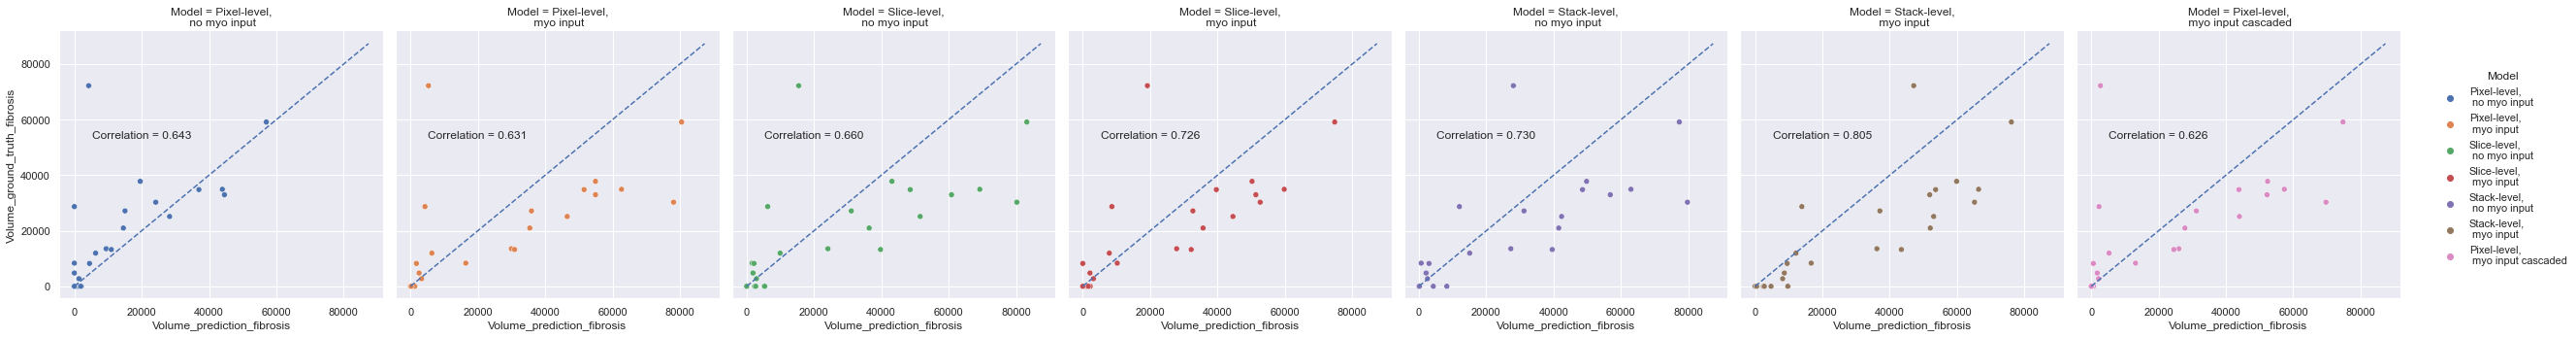

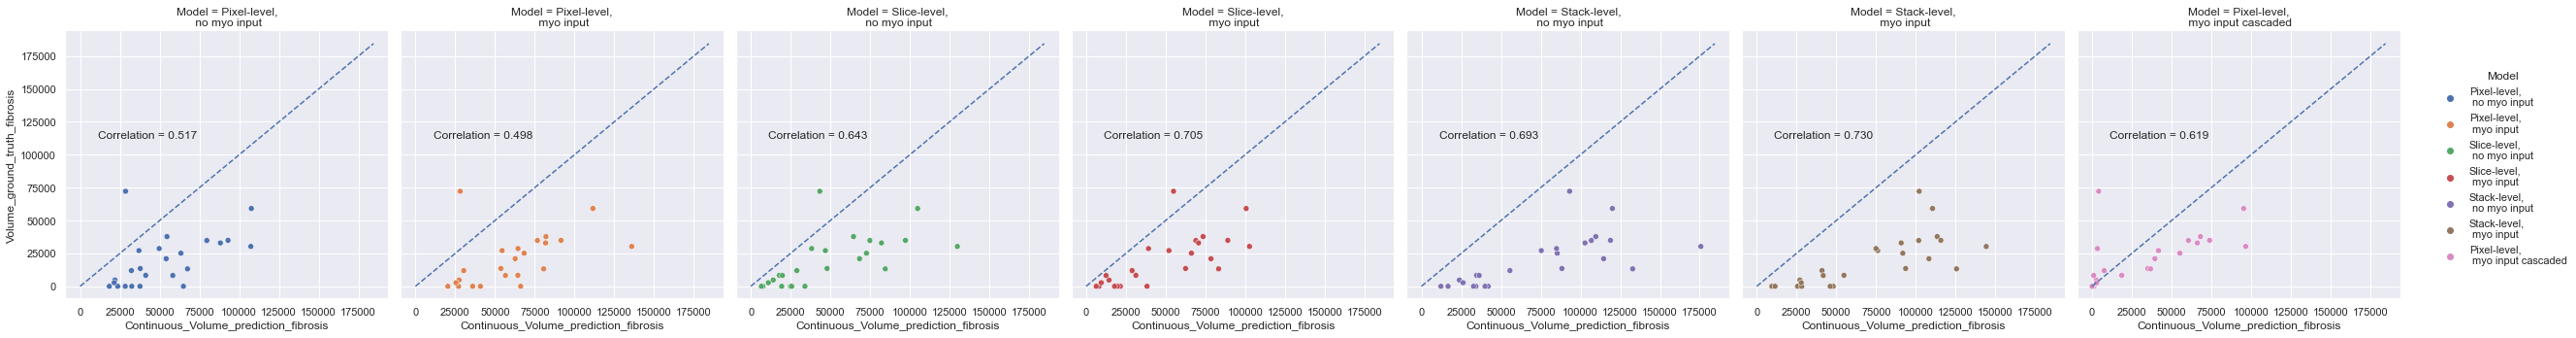

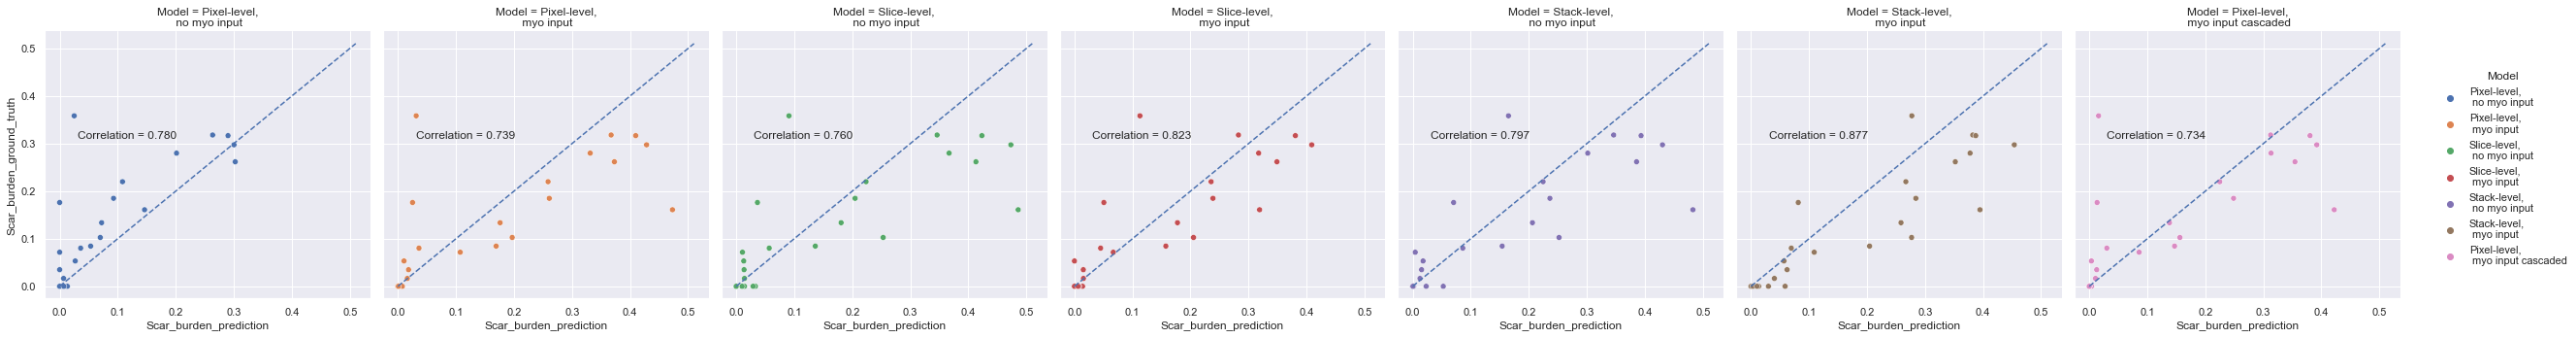

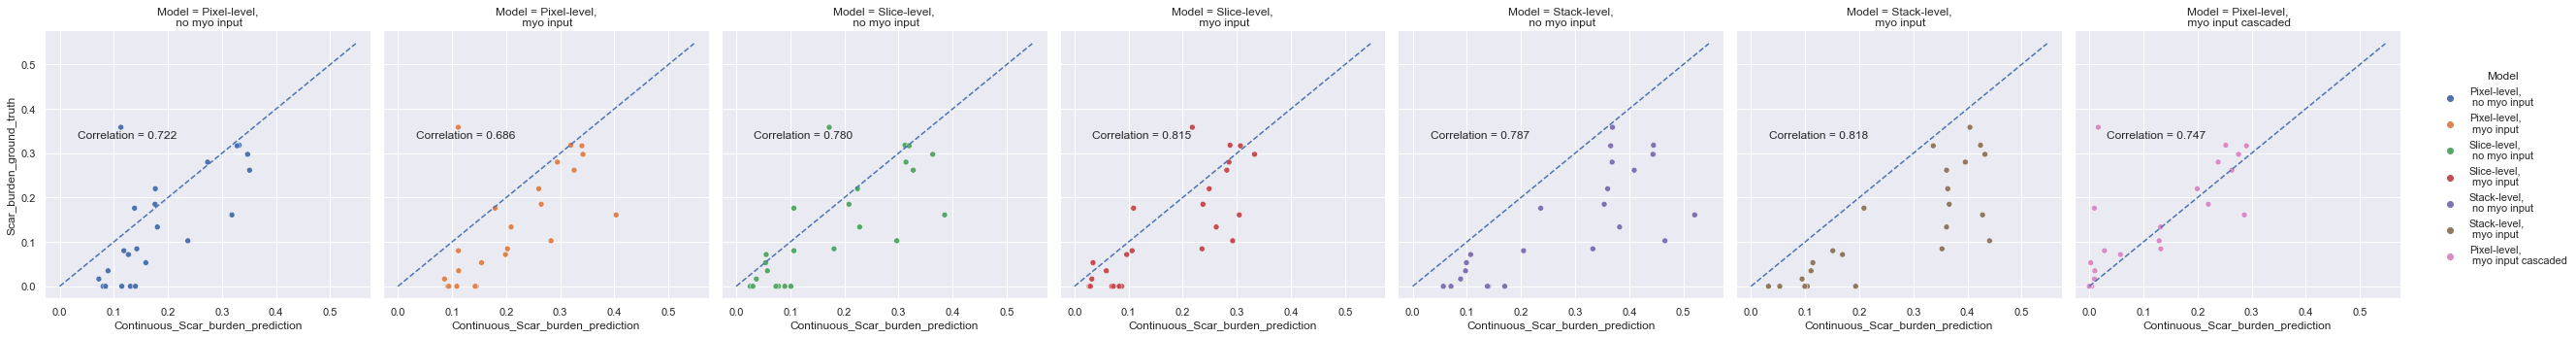

In [32]:
for feature_gt, feature_pred in zip(['Volume_ground_truth_fibrosis', 'Volume_ground_truth_fibrosis', 'Scar_burden_ground_truth', 'Scar_burden_ground_truth'], ['Volume_prediction_fibrosis', 'Continuous_Volume_prediction_fibrosis', 'Scar_burden_prediction', 'Continuous_Scar_burden_prediction']):
    relplot(best_deeprisk_df, y=feature_gt, x=feature_pred, kind='scatter', hue='Model', col='Model',
            restrictions={'Split' : "Test"}, diagonal=True, show_correlation=True, fibrotic_patients_only=False)


Pixel-level,
 no myo input: mean Dice_fibrosis_smooth:0.3003, std 0.2073, median Dice_fibrosis_smooth:0.3168, IQR 0.1417-0.4786
Pixel-level,
 myo input: mean Dice_fibrosis_smooth:0.3492, std 0.2021, median Dice_fibrosis_smooth:0.4020, IQR 0.2428-0.5047
Slice-level,
 no myo input: mean Dice_fibrosis_smooth:0.4111, std 0.1776, median Dice_fibrosis_smooth:0.4402, IQR 0.3463-0.5444
Slice-level,
 myo input: mean Dice_fibrosis_smooth:0.3782, std 0.1917, median Dice_fibrosis_smooth:0.4164, IQR 0.2803-0.5261
Stack-level,
 no myo input: mean Dice_fibrosis_smooth:0.3665, std 0.1571, median Dice_fibrosis_smooth:0.3895, IQR 0.2708-0.4842
Stack-level,
 myo input: mean Dice_fibrosis_smooth:0.3166, std 0.1632, median Dice_fibrosis_smooth:0.3262, IQR 0.2178-0.4288
Pixel-level,
 myo input cascaded: mean Dice_fibrosis_smooth:0.3452, std 0.2082, median Dice_fibrosis_smooth:0.4128, IQR 0.2003-0.4994
Slice-level,
 no myo input cascaded: mean Dice_fibrosis_smooth:0.4017, std 0.1816, median Dice_fibrosis_smo

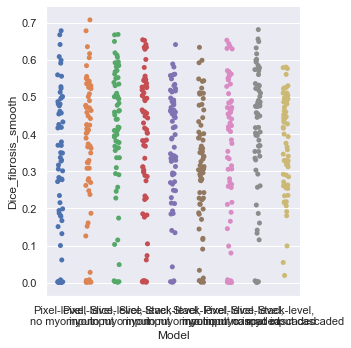

In [177]:
catplot(best_emidec_df, x="Model", y="Dice_fibrosis_smooth", kind='strip', hue='Model', col=None, restrictions={"Split":"Train"}, fibrotic_patients_only=True)
#best_emidec_df[(best_emidec_df['Dice_myocardium'] < 0.78) & ( best_emidec_df['Dice_myocardium'] > 0.7)]

In [146]:
def print_latex_table_info(df, df2=None, row="Model", metrics=['Dice_fibrosis', 'Hausdorff95_3D_fib', 'Specificity_fibrosis', 'Sensitivity_fibrosis'],
                           overarching_column="Split", restrictions={}, fibrotic_patients_only=False, skip_train=True,
                        row_prefixes=None):
    for k, v in restrictions.items():
        df = df[df[k] == v]
        
    if df2 is not None:
        df2 = df2[df2[k] == v]
        
    print(f"{row_prefixes=}")
        
    if fibrotic_patients_only == True:
            df = df[df['Volume_ground_truth_fibrosis'] > 0]
            if df2 is not None:
                df2 = df2[df2['Volume_ground_truth_fibrosis'] > 0]
    if skip_train == True:
            df = df[df['Split'] != "Train"]
            if df2 is not None:
                df2 = df2[df2['Split'] != "Train"]
    
    
    for i, row_value in enumerate(df[row].unique()):
        row_df = df[df[row] == row_value]
        if df2 is not None:
            row_df2 = df2[df2[row] == row_value]
        if row_prefixes is None:
            print("TESTinginghaldk")
            print(f"{row_value=}")
            print()
            row_string = ""
        else:
            row_string = row_prefixes[i]
        for overarching_column_value in row_df[overarching_column].unique():
            sub_df = row_df[row_df[overarching_column] == overarching_column_value]
            if df2 is not None:
                sub_df2 = row_df2[row_df2[overarching_column] == overarching_column_value]
            for metric in metrics:
                row_string += f"& {sub_df[metric].mean(skipna=True):.2f} $\pm$ {sub_df[metric].std(skipna=True):.2f}"
                if df2 is not None:
                    row_string += f"& {sub_df2[metric].mean(skipna=True):.2f} $\pm$ {sub_df2[metric].std(skipna=True):.2f}"
                
        row_string += "\\\\"
        print(row_string)
        print()
    return



#print_latex_table_info(best_deeprisk_df, fibrotic_patients_only=True, skip_train=True)
# small/big fibrosis area
#print_latex_table_info(best_deeprisk_df_small, fibrotic_patients_only=True,
#                       skip_train=True, metrics=['Dice_fibrosis'],
#                       restrictions={"Split": "Val"}, row_prefixes=row_prefixes)
#print("---"*20)
print_latex_table_info(best_emidec_df_small, df2=best_emidec_df_big, fibrotic_patients_only=True,
                       skip_train=False, metrics=['Dice_fibrosis'],
                       restrictions={"Split": "Train"}, row_prefixes=row_prefixes)
#print_latex_table_info(best_deeprisk_df_big, fibrotic_patients_only=True, skip_train=True, metrics=['Dice_fibrosis'], restrictions={"Split": "Test"})

row_prefixes=['\\multirow{2}{*}{Pixel-level} &  LGE ', '&  LGE+myo', '\\multirow{2}{*}{Slice-level} &  LGE ', '&  LGE+myo ', '\\multirow{2}{*}{Stack-level} & LGE ', '&  LGE+myo']
\multirow{2}{*}{Pixel-level} &  LGE & 0.18 $\pm$ 0.20& 0.34 $\pm$ 0.19\\

&  LGE+myo& 0.27 $\pm$ 0.24& 0.39 $\pm$ 0.17\\

\multirow{2}{*}{Slice-level} &  LGE & 0.34 $\pm$ 0.24& 0.44 $\pm$ 0.14\\

&  LGE+myo & 0.32 $\pm$ 0.25& 0.40 $\pm$ 0.16\\

\multirow{2}{*}{Stack-level} & LGE & 0.32 $\pm$ 0.21& 0.38 $\pm$ 0.13\\

&  LGE+myo& 0.25 $\pm$ 0.13& 0.34 $\pm$ 0.16\\



In [145]:

def print_latex_table_info_correlations(df, row="Model",
                                        gt_features=['Volume_ground_truth_fibrosis', 'Volume_ground_truth_fibrosis', 'Scar_burden_ground_truth', 'Scar_burden_ground_truth'],
                                        pred_features = ['Volume_prediction_fibrosis', 'Continuous_Volume_prediction_fibrosis', 'Scar_burden_prediction', 'Continuous_Scar_burden_prediction'],
                                        overarching_column="Split", restrictions={},
                                        fibrotic_patients_only=False, skip_train=True,
                                        row_prefixes=None):
    for k, v in restrictions.items():
        df = df[df[k] == v]
        
    if fibrotic_patients_only == True:
            df = df[df['Volume_ground_truth_fibrosis'] > 0]
    if skip_train == True:
            df = df[df['Split'] != "Train"]
    
    
    for i, row_value in enumerate(df[row].unique()):
        row_df = df[df[row] == row_value]
        if row_prefixes is None:
            print(f"{row_value=}")
            print()
            row_string = ""
        else:
            row_string = row_prefixes[i]
        for overarching_column_value in row_df[overarching_column].unique():
            sub_df = row_df[row_df[overarching_column] == overarching_column_value]
            for gt_feature, pred_feature in zip(gt_features, pred_features):
                correlation = collect_correlations(sub_df, columns=[gt_feature, pred_feature])
                row_string += f"& {correlation.values[0,1]:.3f} "
        row_string += "\\\\"
        print(row_string)
        print()
    return

row_prefixes = ["\multirow{2}{*}{Pixel-level} &  LGE ",
               "&  LGE+myo",
               "\multirow{2}{*}{Slice-level} &  LGE ",
               "&  LGE+myo ",
               "\multirow{2}{*}{Stack-level} & LGE ",
               "&  LGE+myo"]

print_latex_table_info_correlations(best_deeprisk_df_small, fibrotic_patients_only=False, skip_train=False, row_prefixes=None)

row_value='Pixel-level,\n no myo input'

& 0.847 & 0.549 & 0.807 & 0.550 & 0.850 & 0.797 & 0.766 & 0.818 & 0.775 & 0.191 & 0.696 & 0.366 \\

row_value='Pixel-level,\n myo input'

& 0.897 & 0.551 & 0.888 & 0.558 & 0.795 & 0.697 & 0.749 & 0.627 & 0.772 & 0.358 & 0.779 & 0.578 \\

row_value='Slice-level,\n no myo input'

& 0.768 & 0.719 & 0.770 & 0.747 & 0.861 & 0.878 & 0.764 & 0.850 & 0.676 & 0.509 & 0.613 & 0.489 \\

row_value='Slice-level,\n myo input'

& 0.791 & 0.802 & 0.816 & 0.806 & 0.866 & 0.881 & 0.766 & 0.834 & 0.755 & 0.590 & 0.745 & 0.611 \\

row_value='Stack-level,\n no myo input'

& 0.741 & 0.780 & 0.782 & 0.790 & 0.857 & 0.867 & 0.752 & 0.774 & 0.722 & 0.717 & 0.643 & 0.602 \\

row_value='Stack-level,\n myo input'

& 0.772 & 0.793 & 0.801 & 0.783 & 0.775 & 0.844 & 0.667 & 0.748 & 0.823 & 0.698 & 0.815 & 0.657 \\

row_value='Pixel-level,\n myo input cascaded'

& 0.853 & 0.871 & 0.842 & 0.827 & 0.781 & 0.809 & 0.739 & 0.674 & 0.763 & 0.769 & 0.766 & 0.748 \\



# Classification predictions

In [133]:
deeprisk_classification_3D = load_metrics(r"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_classification_3D\drnd_myo_input\version_3\deeprisk_predictions.pkl")
deeprisk_classification_2D = load_metrics(r"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_classification_2D\drnd_no_restriction\version_0\deeprisk_predictions.pkl")

best_deeprisk_df = create_dataframe(best_deeprisk_dict, classification_dict=deeprisk_classification_3D, char_df=char_df, dim="3D", metrics_in_mm=True, gt_only=True, require_multiple_slices=False)
best_deeprisk_df_2D = create_dataframe(best_deeprisk_dict, classification_dict=deeprisk_classification_2D, char_df=char_df, dim="2D", metrics_in_mm=True, gt_only=True, require_multiple_slices=False)

emidec_classification_3D = load_metrics(r"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_classification_3D\drnd_myo_input\version_3\emidec_predictions.pkl")
emidec_classification_2D = load_metrics(r"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_classification_2D\drnd_no_restriction\version_0\emidec_predictions.pkl")

best_emidec_df = create_dataframe(best_emidec_dict, classification_dict=emidec_classification_3D, char_df=None, dim="3D", metrics_in_mm=True, gt_only=True, require_multiple_slices=False)
best_emidec_df_2D = create_dataframe(best_emidec_dict, classification_dict=emidec_classification_2D, char_df=None, dim="2D", metrics_in_mm=True, gt_only=True, require_multiple_slices=False)


C:\Users\rcklein\AppData\Local\Temp\ipykernel_5796\1993984087.py:12: RuntimeWarning: invalid value encountered in long_scalars
  dice = np.array([(2 * intersection.sum() + smoothing) / (sum_pred.sum() + sum_target.sum() + smoothing)])
C:\Users\rcklein\AppData\Local\Temp\ipykernel_5796\1993984087.py:19: RuntimeWarning: invalid value encountered in long_scalars
  sens = np.array([(intersection).sum() / (sum_target).sum()])
C:\Users\rcklein\AppData\Local\Temp\ipykernel_5796\1993984087.py:26: RuntimeWarning: invalid value encountered in long_scalars
  spec = np.array([(intersection).sum() / (sum_pred).sum()])
C:\Users\rcklein\AppData\Local\Temp\ipykernel_5796\1993984087.py:116: RuntimeWarning: invalid value encountered in true_divide
  ratio = calc_contact(circumferences, None, dim=dim, metrics_in_mm=False) / calc_volume(sums, None, dim=dim, metrics_in_mm=False)
C:\Users\rcklein\AppData\Local\Temp\ipykernel_5796\1993984087.py:10: RuntimeWarning: invalid value encountered in true_divide
  d

In [151]:
from torchmetrics import AUROC
import torch

def calc_auc(df, restrictions={}):
    for k, v in restrictions.items():
        df = df[df[k] == v]
        
    auroc = AUROC(pos_label=1)
    predictions = torch.tensor(df['Fibrosis_classification_prediction'].to_numpy())
    labels = torch.tensor((df['Volume_ground_truth_fibrosis'] > 0).to_numpy().astype(int))
    threshold = 0.5
    print(f"Accuracy: {((predictions > threshold) == labels).float().mean()}")
    print(f"True positives: {((predictions > threshold) * labels).float().sum()} / {(labels).float().sum()} TPR : {((predictions > threshold) * labels).float().sum() / (labels).float().sum()}")
    print(f"True negatives: {((predictions < threshold) * (labels == 0)).float().sum()} / {(labels == 0).float().sum()} TNR {((predictions < threshold) * (labels == 0)).float().sum()/(labels == 0).float().sum()}")
    for i in range(10):
        print(labels[i].item(), predictions[i].item())
    print(auroc(predictions, labels))
    
calc_auc(best_emidec_df_2D, restrictions={'Model' : "Pixel-level,\n no myo input", 'Split' : 'Train'})

Accuracy: 0.7853107452392578
True positives: 319.0 / 394.0 TPR : 0.8096446990966797
True negatives: 237.0 / 314.0 TNR 0.7547770738601685
0 0.0017795440508052707
0 0.0017996295355260372
0 0.002085502725094557
0 0.062296073883771896
0 0.3009936511516571
0 0.021349351853132248
0 0.3304770886898041
0 0.37179768085479736
0 0.14800460636615753
0 0.05877376347780228
tensor(0.8628)


In [428]:
(best_deeprisk_df['Volume_ground_truth_fibrosis'] > 0).to_numpy().astype(int)
((best_emidec_df['Dice_fibrosis'] > 0.5) * (best_emidec_df['Model'] == 'Stack-level,\n no myo input')).sum()


13